In [2]:
from Bio import pairwise2
import random
from Bio.SubsMat import MatrixInfo as matlist
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def readFastaAsDict(filename):
    f = open(filename)
    flines = [x.strip() for x in f.readlines()]
    f.close()
    seqDict = {}
    freqs = {}
    for line in flines:
        if line == "" or line[0] == "#":
            continue
        if line[0] == ">":
            cur = line[1:]
            seqDict[cur] = ""
        else:
            for char in line:
                if char in ["U", "X"]:
                    continue
                if char in freqs:
                    freqs[char] += 1
                else:
                    freqs[char] = 1
            seqDict[cur] += line
    
    tot = 0
    for aa in freqs:
        tot += freqs[aa]
    normFreqs = {aa : freqs[aa] / tot for aa in freqs}
    
    return seqDict, normFreqs, tot

def makeRandSeq(length, freqDict):
    seq = ""
    for i in range(length):
        ranNum = random.random()
        tot = 0
        for aa in freqDict:
            tot += freqDict[aa]
            if tot > ranNum:
                break
        seq += aa
    return seq

def getMaxScore(seq, matrix):
    tot = 0
    for aa in seq:
        tot += matrix[(aa, aa)]
    return tot

def evolvabilityDist(filename, length=100, numTests=100, matrix=matlist.blosum62, fusion=True):
    seqDict, aaFreqs, _ = readFastaAsDict(filename)
    evolvabilities = []
    maxMat = max(list(matrix.values()))
    print(filename)
    allNames = list(seqDict.keys())
    for i in range(numTests):
        print("Test#:", i)
        randSeq = makeRandSeq(length, aaFreqs)
        #print(randSeq)
        aligns = {}
        sites = {}
        for name in allNames:
            #print(name)
            seq = seqDict[name].replace("U","").replace("X","")
            if len(seq) < length:
                aSec, aRandSeq, score, _, _ = pairwise2.align.globalds(
                                            seq, randSeq, matrix, -50,
                                            -1, penalize_end_gaps=True)[0]
            else:
                aSec, aRandSeq, score, _, _ = pairwise2.align.globalds(
                                            seq, randSeq, matrix, -50,
                                            -1, penalize_end_gaps=False)[0]
            
            prevGapSec = False
            prevGapRandSec = False
            begGapSec = True
            begGapRandSec = True
            aScores = []
            for site in range(len(aSec)):
                val = 0
                if aSec[site] == '-':
                    if begGapSec:
                        val += 0
                    elif prevGapSec:
                        val -= 1
                    else:
                        val -= 11
                        prevGapSec = True
                if aRandSeq[site] == '-':
                    if begGapRandSec:
                        val += 0
                    elif prevGapRandSec:
                        val -= 1
                    else:
                        val -= 11
                        prevGapRandSec = True
                else:
                    prevGapRandSec = False
                    begGapRandSec = False
                    if aSec[site] != '-':
                        prevGapSec = False
                        begGapSec = False
                        val = matrix.get((aSec[site], aRandSeq[site]))
                        if val == None:
                            val = matrix.get((aRandSeq[site], aSec[site]))
                    else:
                        val = -5
                aScores.append(val)
            forward = [0]
            cur = 0
            for site in range(len(aRandSeq)):
                aa = aRandSeq[site]
                cur += aScores[site]
                if aa != '-':
                    forward.append(forward[-1] + cur)
                    cur = 0

            backward = [0]
            cur = 0
            first = True
            for site in range(-1, -len(aSec) - 1, -1):
                aa = aRandSeq[site]
                cur += aScores[site]
                if aa != '-':
                    if first:
                        first = False
                        backward.insert(0, aScores[site])
                    else:
                        backward.insert(0, backward[0] + cur)
                    cur = 0
            if fusion:
                aligns[name] = (forward, backward, (aRandSeq, aSec))
            else:
                aligns[name] = forward[-1]
            #print(len(forward), len(backward))
            #print(aRandSeq + "\n", aSec, aScores, forward[-1], backward[0], score)
            
        if fusion:
            bestPairs = {}
            
            for j in range(len(allNames)):
                name1 = allNames[j]
                forward1, backward1, _ = aligns[name1]
                for k in range(len(allNames)):
                    name2 = allNames[k]
                    if name1 == name2:
                        continue
                    forward2, backward2, _ = aligns[name2]
                    scores = []
                    for end in range(length // 10, length - (length // 10)):
                        scores.append(forward1[end] + backward2[end])
                    bestScore = max(scores)
                    bestPairs[(name1, name2)] = (bestScore, scores.index(bestScore) + (length // 10))
            bestScore = max([x[0] for x in bestPairs.values()])
        else:
            bestScore = max(list(aligns.values()))
        maxPossible = getMaxScore(randSeq, matrix)
        print(bestScore, maxPossible)
        evolvabilities.append((bestScore, maxPossible))
        #print(bestScore)
    return evolvabilities

In [27]:
out = open("randomLactAcidDiversity.fasta", "w")
seqDict, freqs, tot = readFastaAsDict("GCF_003047065.1_ASM304706v1_protein.faa")
#print(freqs)
i = 0
for name in seqDict:
    i += 1
    length = len(seqDict[name])
    out.write(">" + str(i) + "\n" + makeRandSeq(length, freqs) + "\n")
out.close()
seqDict2, freqs2, tot2 = readFastaAsDict("randomLactAcidDiversity.fasta")
#print(freqs2)
print(tot, tot2)
for aa in freqs:
    print(aa, freqs[aa], freqs2[aa])


551650 551650
M 0.026507749478836218 0.026437052478926856
K 0.07949605728269736 0.07949061905193511
V 0.06794162965648509 0.06891144747575456
R 0.03692196138856159 0.03683132420919061
P 0.0355424635185353 0.03567479380041693
S 0.05884709507840116 0.058749206924680504
C 0.0054327925314964194 0.005394724916160609
E 0.05688933200398803 0.056162421825432796
H 0.02012326656394453 0.020215716486902926
I 0.07832865041239917 0.07786277531043234
G 0.06474213722468956 0.06474213722468956
A 0.07088371249886703 0.07124807395993836
N 0.0584337895404695 0.058167316233118826
Q 0.0379334723103417 0.03805855161787365
D 0.06131423910087918 0.06183087102329376
T 0.057891779207831055 0.057599927490256504
L 0.09035076588416568 0.09007341611529049
F 0.04307985135502583 0.04315417384211003
Y 0.038877911719387294 0.03909544094987764
W 0.010461343242998277 0.010300009063717938


In [26]:
# A full proteome of Lactobacillus acidophilus
distsEmpFusLA = evolvabilityDist("GCF_003047065.1_ASM304706v1_protein.faa", length=100, numTests=100)
distsEmpNoFusLA = evolvabilityDist("GCF_003047065.1_ASM304706v1_protein.faa", length=100, numTests=100, fusion=False)
distsSimFusLA = evolvabilityDist("randomLactAcidDiversity.fasta", length=100, numTests=100)
distsSimNoFusLA = evolvabilityDist("randomLactAcidDiversity.fasta", length=100, numTests=100, fusion=False)

GCF_003047065.1_ASM304706v1_protein.faa
Test#: 0
81 503
Test#: 1
63 517
Test#: 2
57 525
Test#: 3
57 512
Test#: 4
45 522
Test#: 5
72 512
Test#: 6
72 521
Test#: 7
67 509
Test#: 8
71 498
Test#: 9
48 532
Test#: 10
57 506
Test#: 11
54 506
Test#: 12
66 508
Test#: 13
81 518
Test#: 14
61 498
Test#: 15
47 540
Test#: 16
62 508
Test#: 17
103 521
Test#: 18
66 512
Test#: 19
55 529
Test#: 20
79 503
Test#: 21
74 525
Test#: 22
64 500
Test#: 23
63 526
Test#: 24
53 528
Test#: 25
69 537
Test#: 26
57 526
Test#: 27
74 498
Test#: 28
61 526
Test#: 29
53 506
Test#: 30
68 525
Test#: 31
69 525
Test#: 32
58 519
Test#: 33
69 508
Test#: 34
61 528
Test#: 35
58 517
Test#: 36
66 522
Test#: 37
69 521
Test#: 38
87 519
Test#: 39
54 553
Test#: 40
56 521
Test#: 41
86 499
Test#: 42
65 502
Test#: 43
90 534
Test#: 44
59 515
Test#: 45
59 513
Test#: 46
71 483
Test#: 47
57 526
Test#: 48
69 514
Test#: 49
75 519
Test#: 50
66 511
Test#: 51
61 516
Test#: 52
60 529
Test#: 53
71 516
Test#: 54
73 529
Test#: 55
54 519
Test#: 56
65 509


22.985340980720732 21.707980099493366
16.9168880116882 19.69181301962823


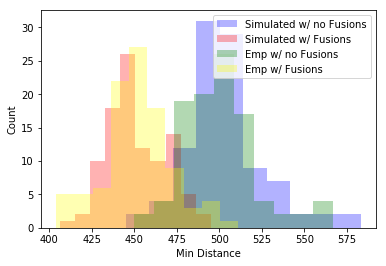

In [7]:
distsEmpFusLA = [(int(x.split()[0]), int(x.split()[1])) for x in open("distsEmpFusLA.txt").readlines()]
distsEmpNoFusLA = [(int(x.split()[0]), int(x.split()[1])) for x in open("distsEmpNoFusLA.txt").readlines()]
distsSimFusLA = [(int(x.split()[0]), int(x.split()[1])) for x in open("distsSimFusLA.txt").readlines()]
distsSimNoFusLA = [(int(x.split()[0]), int(x.split()[1])) for x in open("distsSimNoFusLA.txt").readlines()]

print(np.std([x[0] - x[1] for x in distsSimNoFusLA]), np.std([x[0] - x[1] for x in distsEmpNoFusLA]))
print(np.std([x[0] - x[1] for x in distsSimFusLA]), np.std([x[0] - x[1] for x in distsEmpFusLA]))

f = plt.hist([x[1] - x[0] for x in distsSimNoFusLA], color="blue", alpha=0.3, label="Simulated w/ no Fusions")
f = plt.hist([x[1] - x[0] for x in distsSimFusLA], color="red", alpha=0.3, label="Simulated w/ Fusions")
f = plt.hist([x[1] - x[0] for x in distsEmpNoFusLA], color="green", alpha=0.3, label="Emp w/ no Fusions")
f = plt.hist([x[1] - x[0] for x in distsEmpFusLA], color="yellow", alpha=0.3, label="Emp w/ Fusions")


f = plt.xlabel("Min Distance")
f = plt.ylabel("Count")
f = plt.legend()

In [3]:
out = open("randomDiversity.fasta", "w")
seqDict, freqs, tot = readFastaAsDict("goodCentroids.fasta")
#print(freqs)
i = 0
for name in seqDict:
    i += 1
    length = len(seqDict[name])
    out.write(">" + str(i) + "\n" + makeRandSeq(length, freqs) + "\n")
out.close()
seqDict2, freqs2, tot2 = readFastaAsDict("randomDiversity.fasta")
#print(freqs2)
print(tot, tot2)
for aa in freqs:
    print(aa, freqs[aa], freqs2[aa])


1410500 1410523
M 0.02547394540942928 0.02557420190950449
A 0.07067139312300602 0.07087654720979382
S 0.06979794399149238 0.0701207991645652
F 0.040103509393831976 0.04059628946142672
Q 0.04390287132222616 0.04363771452149309
R 0.05580716058135413 0.05578710875327804
K 0.06291740517546969 0.06281358049461086
G 0.06319390287132223 0.06302272277729608
L 0.09913647642679901 0.09918803167335803
I 0.052083658277206665 0.052236652645862566
T 0.05169088975540589 0.05154045697943245
E 0.07150301311591634 0.07146569038576471
D 0.05391208791208791 0.05366520078013616
V 0.06529883020205601 0.0651829144225227
N 0.0385409429280397 0.03855449361690664
W 0.011946118397731301 0.011961520655813481
Y 0.030491315136476425 0.030565967375221815
H 0.024996100673520028 0.0252062532833566
C 0.018630981921304503 0.018308811696087196
P 0.049901453385324354 0.049695042193569336


In [23]:
distsEmp = evolvabilityDist("goodCentroids.fasta", length=100, numTests=10)
distsSim = evolvabilityDist("randomDiversity.fasta", length=100, numTests=10)

goodCentroids.fasta
Test#: 0
-4
Test#: 1


KeyboardInterrupt: 

43.14 43.79


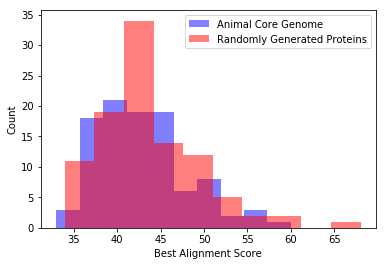

In [24]:
print(np.mean(distsEmp), np.mean(distsSim))
f = plt.hist(distsEmp, color="blue", alpha=0.5, label="Animal Core Genome")
f = plt.hist(distsSim, color="red", alpha=0.5, label="Randomly Generated Proteins")
f = plt.xlabel("Best Alignment Score")
f = plt.ylabel("Count")
f = plt.legend()

In [25]:
out = open("randomDiversityEColi.fasta", "w")
seqDict, freqs, tot = readFastaAsDict("ecoli.fasta")
#print(freqs)
i = 0
for name in seqDict:
    i += 1
    length = len(seqDict[name])
    out.write(">" + str(i) + "\n" + makeRandSeq(length, freqs) + "\n")
out.close()
seqDict2, freqs2, tot2 = readFastaAsDict("randomDiversityEColi.fasta")
#print(freqs2)
print(tot, tot2)
for aa in freqs:
    print(aa, freqs[aa], freqs2[aa])

1560427 1560430
M 0.0274418476481117 0.027330287164435443
P 0.043883501118604076 0.043933402972257646
R 0.05592379521759108 0.05593137788942791
S 0.05999127161988353 0.06000589581077011
L 0.10398692152853033 0.10420909621065988
K 0.04517609603012509 0.045265087187506006
G 0.07327161091162868 0.07340989342681184
F 0.03794346034771252 0.03810488134680825
I 0.05918956798363525 0.059009375620822466
D 0.05243436572169028 0.05227917945694456
H 0.02217598131793413 0.022020212377357525
V 0.06995713352819452 0.06969553264164365
E 0.058677528650811606 0.058748550079144854
A 0.09410372929973655 0.0939862730144896
T 0.05501891469450349 0.05522452144601168
W 0.015255439696954743 0.015172740847074205
N 0.0407862719627384 0.04095217343937248
Q 0.04443655486607191 0.044090410976461616
Y 0.02887863386111622 0.02925155245669463
C 0.011467373994425885 0.011379555635305653


In [26]:
distsEmp = evolvabilityDist("ecoli.fasta", length=100, numTests=100)
distsSim = evolvabilityDist("randomDiversityEColi.fasta", length=100, numTests=100)

ecoli.fasta
44.0
47.0
49.0
42.0
36.0
60.0
40.0
45.0
47.0
46.0
51.0
46.0
50.0
37.0
41.0
42.0
45.0
43.0
40.0
45.0
45.0
54.0
45.0
41.0
45.0
57.0
45.0
56.0
39.0
43.0
43.0
39.0
51.0
46.0
44.0
45.0
46.0
47.0
42.0
37.0
44.0
46.0
47.0
41.0
50.0
43.0
44.0
37.0
39.0
43.0
41.0
44.0
50.0
41.0
46.0
43.0
45.0
56.0
44.0
49.0
41.0
43.0
47.0
45.0
46.0
41.0
49.0
53.0
55.0
44.0
46.0
45.0
44.0
43.0
46.0
47.0
51.0
42.0
47.0
54.0
38.0
37.0
47.0
40.0
51.0
38.0
42.0
44.0
40.0
39.0
44.0
42.0
44.0
47.0
46.0
46.0
48.0
55.0
42.0
47.0
randomDiversityEColi.fasta
41.0
43.0
46.0
43.0
40.0
44.0
51.0
43.0
42.0
41.0
39.0
54.0
40.0
46.0
45.0
36.0
51.0
43.0
41.0
38.0
45.0
37.0
40.0
48.0
45.0
51.0
40.0
44.0
52.0
46.0
48.0
52.0
47.0
50.0
40.0
47.0
43.0
46.0
39.0
52.0
39.0
42.0
43.0
44.0
45.0
48.0
51.0
49.0
51.0
47.0
54.0
47.0
42.0
48.0
47.0
42.0
44.0
43.0
47.0
42.0
43.0
40.0
53.0
46.0
51.0
39.0
36.0
40.0
46.0
41.0
51.0
46.0
47.0
38.0
50.0
50.0
43.0
42.0
41.0
45.0
42.0
50.0
49.0
46.0
42.0
45.0
46.0
61.0
43.0
43.0
43.0
45.0
4

45.05 45.02


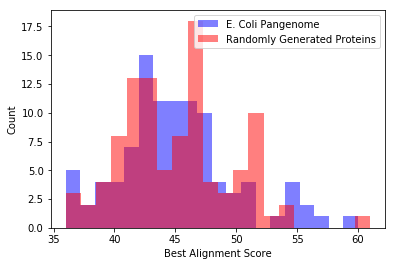

In [106]:
print(np.mean(distsEmp), np.mean(distsSim))
f = plt.hist(distsEmp, color="blue", bins=20, alpha=0.5, label="E. Coli Pangenome")
f = plt.hist(distsSim, color="red", bins=20, alpha=0.5, label="Randomly Generated Proteins")
f = plt.xlabel("Best Alignment Score")
f = plt.ylabel("Count")
f = plt.legend()

In [6]:
matrix = matlist.blosum62
#pairwise2.align.globalds("GSPKVVKEMFENAQHR", "MASFQRKGLQAGENFYVRQDGTRSYFFTDGKRNGVSP", matrix, -11, -1)
print(matrix)

{('W', 'F'): 1, ('L', 'R'): -2, ('S', 'P'): -1, ('V', 'T'): 0, ('Q', 'Q'): 5, ('N', 'A'): -2, ('Z', 'Y'): -2, ('W', 'R'): -3, ('Q', 'A'): -1, ('S', 'D'): 0, ('H', 'H'): 8, ('S', 'H'): -1, ('H', 'D'): -1, ('L', 'N'): -3, ('W', 'A'): -3, ('Y', 'M'): -1, ('G', 'R'): -2, ('Y', 'I'): -1, ('Y', 'E'): -2, ('B', 'Y'): -3, ('Y', 'A'): -2, ('V', 'D'): -3, ('B', 'S'): 0, ('Y', 'Y'): 7, ('G', 'N'): 0, ('E', 'C'): -4, ('Y', 'Q'): -1, ('Z', 'Z'): 4, ('V', 'A'): 0, ('C', 'C'): 9, ('M', 'R'): -1, ('V', 'E'): -2, ('T', 'N'): 0, ('P', 'P'): 7, ('V', 'I'): 3, ('V', 'S'): -2, ('Z', 'P'): -1, ('V', 'M'): 1, ('T', 'F'): -2, ('V', 'Q'): -2, ('K', 'K'): 5, ('P', 'D'): -1, ('I', 'H'): -3, ('I', 'D'): -3, ('T', 'R'): -1, ('P', 'L'): -3, ('K', 'G'): -2, ('M', 'N'): -2, ('P', 'H'): -2, ('F', 'Q'): -3, ('Z', 'G'): -2, ('X', 'L'): -1, ('T', 'M'): -1, ('Z', 'C'): -3, ('X', 'H'): -1, ('D', 'R'): -2, ('B', 'W'): -4, ('X', 'D'): -1, ('Z', 'K'): 1, ('F', 'A'): -2, ('Z', 'W'): -3, ('F', 'E'): -3, ('D', 'N'): 1, ('B', 'K'

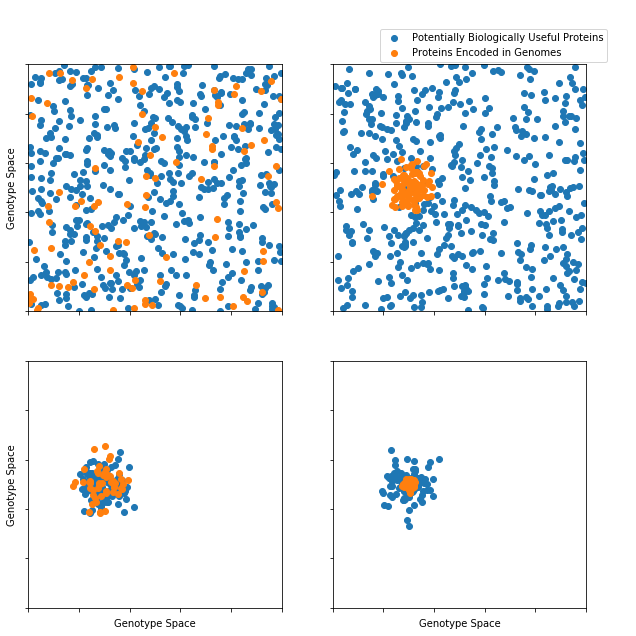

In [79]:
widex = np.random.randint(low=0, high=10000, size=500)
widey = np.random.randint(low=0, high=10000, size=500)
narrowx = np.random.normal(3000, 500, size=100) 
narrowy = np.random.normal(5000, 500, size=100)
fig, axs = plt.subplots(2, 2, figsize=(10,10))
axs[0,1].scatter(widex, widey, label="Potentially Biologically Useful Proteins")
axs[0,1].scatter(narrowx, narrowy, label="Proteins Encoded in Genomes")
fig.legend(borderaxespad=2.9)



widex = np.random.normal(3000, 500, size=100)
widey = np.random.normal(5000, 500, size=100)
narrowx = np.random.normal(3000, 500, size=50)
narrowy = np.random.normal(5000, 500, size=50)
axs[1,0].scatter(widex, widey, label="Potentially Biologically Relevent Proteins")
axs[1,0].scatter(narrowx, narrowy, label="PBR Proteins Encoded in Genomes")

widex = np.random.randint(low=0, high=10000, size=500)
widey = np.random.randint(low=0, high=10000, size=500)
narrowx = np.random.randint(low=0, high=10000, size=100)
narrowy = np.random.randint(low=0, high=10000, size=100)
axs[0,0].scatter(widex, widey, label="Potentially Biologically Useful Proteins")
axs[0,0].scatter(narrowx, narrowy, label="Proteins Encoded in Genomes")

widex = np.random.normal(3000, 500, size=100)
widey = np.random.normal(5000, 500, size=100)
narrowx = np.random.normal(3000, 100, size=100)
narrowy = np.random.normal(5000, 100, size=100)
axs[1,1].scatter(widex, widey, label="Potentially Biologically Useful Proteins")
axs[1,1].scatter(narrowx, narrowy, label="Proteins Encoded in Genomes")

for ax in axs.flat:
    ax.set_xlim(0, 10000)
    ax.set_ylim(0, 10000)
    ax.set_ylabel("Genotype Space")
    ax.set_xlabel("Genotype Space")
    ax.label_outer()
    ax.set_yticklabels([])
    ax.set_xticklabels([])

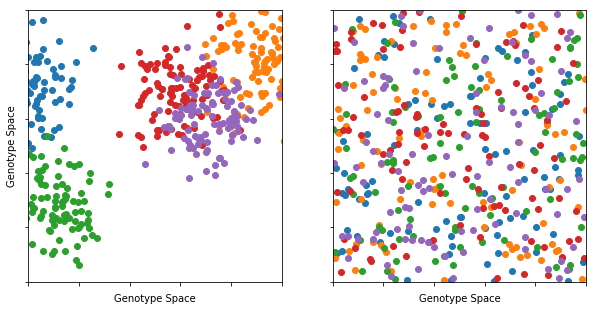

In [105]:
widex = np.random.randint(low=0, high=10000, size=500)
widey = np.random.randint(low=0, high=10000, size=500)
narrowxs = [np.random.normal(np.random.randint(0, 10) * 1000, 1000, size=100) for x in range(5)]
narrowys = [np.random.normal(np.random.randint(0, 10) * 1000, 1000, size=100) for x in range(5)]
fig, axs = plt.subplots(1, 2, figsize=(10,5))
for i in range(5):
    narrowx = narrowxs[i]
    narrowy = narrowys[i]
    axs[0].scatter(narrowx, narrowy, label="Proteins Encoded in Genomes")

widexs = [np.random.randint(low=0, high=10000, size=100) for x in range(5)]
wideys = [np.random.randint(low=0, high=10000, size=100) for x in range(5)]
for i in range(5):
    narrowx = widexs[i]
    narrowy = wideys[i]
    axs[1].scatter(narrowx, narrowy, label="Proteins Encoded in Genomes")

for ax in axs.flat:
    ax.set_xlim(0, 10000)
    ax.set_ylim(0, 10000)
    ax.set_ylabel("Genotype Space")
    ax.set_xlabel("Genotype Space")
    ax.label_outer()
    ax.set_yticklabels([])
    ax.set_xticklabels([])